In [1]:
import h5py
import sys
import os
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits import mplot3d


In [2]:
def plot_sfile_surface(fname, intf=0):
    sfile = h5py.File(fname, 'r')    
    intf_name = 'z_values_%d' % intf
    topo = -sfile['Z_interfaces'][intf_name][:]

    X = np.arange(1, topo.shape[0]+1)
    Y = np.arange(1, topo.shape[1]+1)
    X, Y = np.meshgrid(X, Y)

    fig = plt.figure()
    ax = fig.gca(projection='3d')
    surf = ax.plot_surface(X, Y, topo, rstride=1, cstride=1, linewidth=0, antialiased=False, cmap='viridis')
    fig.colorbar(surf, shrink=0.5, aspect=5)

    plt.show()
    sfile.close()    
    
def plot_sfile_intf(fname, intf=0, minv=1e9, maxv=-1e9):
    sfile = h5py.File(fname, 'r')
    intf_name = 'z_values_%d' % intf
    topo = -sfile['Z_interfaces'][intf_name][:]
    nlvs = 21
    minv = np.minimum(minv, np.min(topo))
    maxv = np.maximum(maxv, np.max(topo))
    if minv >= maxv:
        nlvs = 2
        maxv = minv+1
    lvs = np.linspace(minv, maxv, nlvs)
    
    fig, ax = plt.subplots(constrained_layout=True)    
    CS1 = ax.contour(topo, levels=lvs, colors='black', linewidths=.2)
    CS = ax.contourf(topo, levels=lvs)
    plt.gca().set_aspect('equal', adjustable='box')
    cbar = fig.colorbar(CS)

    sfile.close()
    
def get_ngrid_sfile(fname):
    sfile = h5py.File(fname, 'r')
    ngrid = sfile.attrs['ngrids']
    sfile.close()
    return ngrid

def read_sfile(fname, var, plane, coordinate, pnr, verbose=0):
        
    sfile = h5py.File(fname, 'r')
    ngrid = sfile.attrs['ngrids']
    
    if pnr >= ngrid:
        print('grid number larger than ngrid in image file')
        return -1
        
    if plane == 'z':
        for i in range(0, ngrid):
            grid_name = "grid_%d" % (i)
            grid_size = sfile['Material_model'][grid_name].attrs['Horizontal grid size']
            nk        = sfile['Material_model'][grid_name]['Cp'].shape[2]
            if coordinate <= nk * grid_size:
                pnr = i
                break
            else:
                coordinate -= nk * grid_size
                
    top_name = "z_values_%d" % (pnr)
    bot_name = "z_values_%d" % (pnr+1)
    intf_top = -sfile['Z_interfaces'][top_name][:]
    intf_bot = -sfile['Z_interfaces'][bot_name][:]    
    
    useGhost = False
    if intf_top.shape != intf_bot.shape:
        intf_top = intf_top[::2, ::2]
        useGhost = True

    grid_name = "grid_%d" % (pnr)
    grid_size = sfile['Material_model'][grid_name].attrs['Horizontal grid size']
    
    coordinate = int(coordinate/grid_size)
            
    ni = sfile['Material_model'][grid_name][var].shape[0]
    nj = sfile['Material_model'][grid_name][var].shape[1]    
    nk = sfile['Material_model'][grid_name][var].shape[2]

    if verbose > 0:
        print('coordinate=', coordinate)
        print('grid_size:', grid_size)
        print('ni, nj, nk', ni, nj, nk)
    
    ghost = 1
    if plane == 'x':
        if useGhost:
            nk += ghost
        x = np.zeros((nk, nj))
        y = np.zeros((nk, nj))
        data = np.transpose(sfile['Material_model'][grid_name][var][coordinate,:,:])
        if useGhost:
            ghostzone = np.zeros((ghost, data.shape[1]))
            for i in range(0, ghost):
                for j in range(0, data.shape[1]):
                    # f = interpolate.interp1d(grid_size*range(0, data.shape[0]), data[:,j], fill_value = "extrapolate")
                    # ghostzone[i, j] = f((ghost-i)*grid_size)
                    ghostzone[i, j] = data[0, j]

            data = np.vstack([ghostzone, data])
        for k in range(0, nk):
            x[k,:] = grid_size*range(0, nj)
            y[k,:] = intf_top[coordinate, :] - k*((intf_top[coordinate, :]-intf_bot[coordinate, :])/nk)
            if k < ghost:
                y[k,:] = y[k,:] + (ghost-k)*grid_size

    elif plane == 'y':
        if useGhost:
            nk += ghost
        x = np.zeros((nk, ni))
        y = np.zeros((nk, ni))
        data = np.transpose(sfile['Material_model'][grid_name][var][:,coordinate,:])
        if useGhost:
            ghostzone = np.zeros((ghost, data.shape[1]))
            for i in range(0, ghost):
                for j in range(0, data.shape[1]):
                    # f = interpolate.interp1d(grid_size*range(0, data.shape[0]), data[:,j], fill_value = "extrapolate")
                    # ghostzone[i, j] = f((ghost-i)*grid_size)
                    ghostzone[i, j] = data[0, j]
            data = np.vstack([ghostzone, data])
        for k in range(0, nk):
            x[k,:] = grid_size*range(0, ni)
            y[k,:] = intf_top[:, coordinate] - k*((intf_top[:, coordinate]-intf_bot[:, coordinate])/nk)
            if k < ghost:
                y[k,:] = y[k,:] + (ghost-k)*grid_size

    elif plane == 'z':
        data = np.transpose(sfile['Material_model'][grid_name][var][:,:,coordinate])
        # print('Read z data:', np.min(data), np.max(data))
        # print('grid_size', grid_size)
        # print(data.shape)
        nj = data.shape[0]
        ni = data.shape[1]
        x = grid_size*range(0, ni)
        y = grid_size*range(0, nj)
    else:
        print('ploting %s cross-section is not supported yet!' % plane)
    return data, x, y
        
def plot_sfile(fname, var, plane, coordinate, minv=1e9, maxv=-1e9, savefig=False, nlvs=21, verbose=0):
    ngrid = get_ngrid_sfile(fname)
    if plane != 'x' and plane != 'y' and plane != 'z':
        print('ploting %s cross-section is not supported yet!' % plane)
        return

    if plane == 'z':
        print('currently only support plotting z plane depth (m), plotted data plane is parallel to the interface (not flat)')
        ngrid = 1
        
    x = []
    y = []
    im = []
    for i in range(0, ngrid):
        [im0, x0, y0] = read_sfile(fname, var, plane, coordinate, i, verbose=0)
        x0 = x0/1000
        y0 = y0/1000
        x.append(x0)
        y.append(y0)
        im.append(im0)

        minv = np.minimum(minv, np.min(im0))
        maxv = np.maximum(maxv, np.max(im0))
    if minv >= maxv:
        #print('All equal values')
        nlvs = 2
        maxv = minv+1
    lvs = np.linspace(minv, maxv, nlvs)
    #print(lvs)

    fig, ax = plt.subplots(constrained_layout=True)

    maxy = -1e9
    miny =  1e9
    for i in range(0, ngrid):
        if plane == 'x':
            xlabel = 'y (km)'
            ylabel = 'depth (km)'
        elif plane == 'y':
            xlabel = 'y (km)'
            ylabel = 'depth (km)'
        if plane == 'z':
            xlabel = 'x (km)'
            ylabel = 'y (km)'
            
        CS  = ax.contourf(x[i], y[i], im[i], levels=lvs)
        CS1 = ax.contour(x[i], y[i], im[i], levels=lvs, colors='black', linewidths=.1)

        maxy = np.maximum(maxy, np.max(y[i]))
        miny = np.minimum(miny, np.min(y[i]))
        
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_aspect('equal')
    if plane == 'z':
        ax.set_ylim(np.max(y[0]), np.min(y[0]))

    title = os.path.basename(fname)
    ax.set_title(title)
    cbar = fig.colorbar(CS)
    if savefig:
        fig.savefig(fname+'.png')
        plt.close(fig)
    else:
        fig.show()


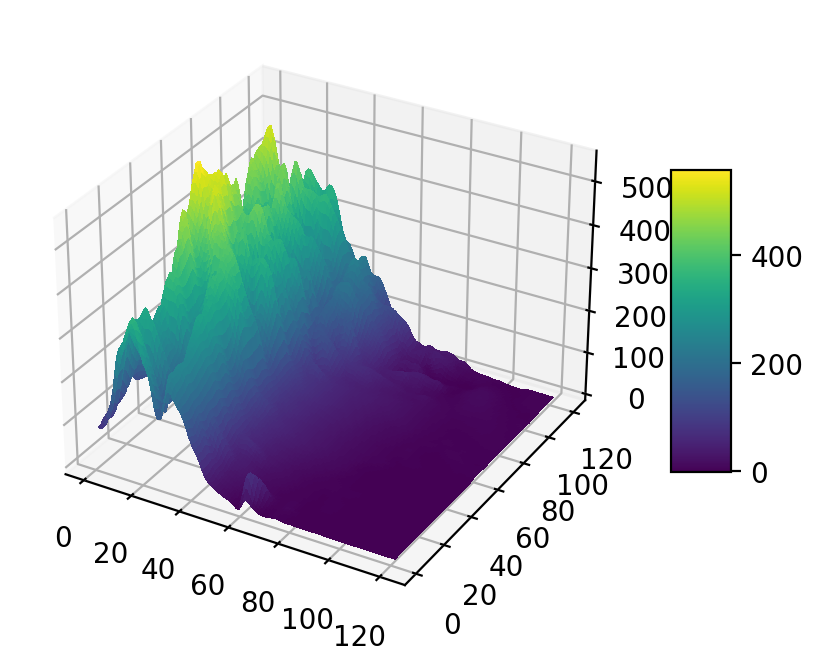

In [3]:
matplotlib.rcParams['figure.dpi'] = 200
fname='/global/u1/h/houhun/sw4/examples/sfile/berkeley.sfile'
plot_sfile_surface(fname)

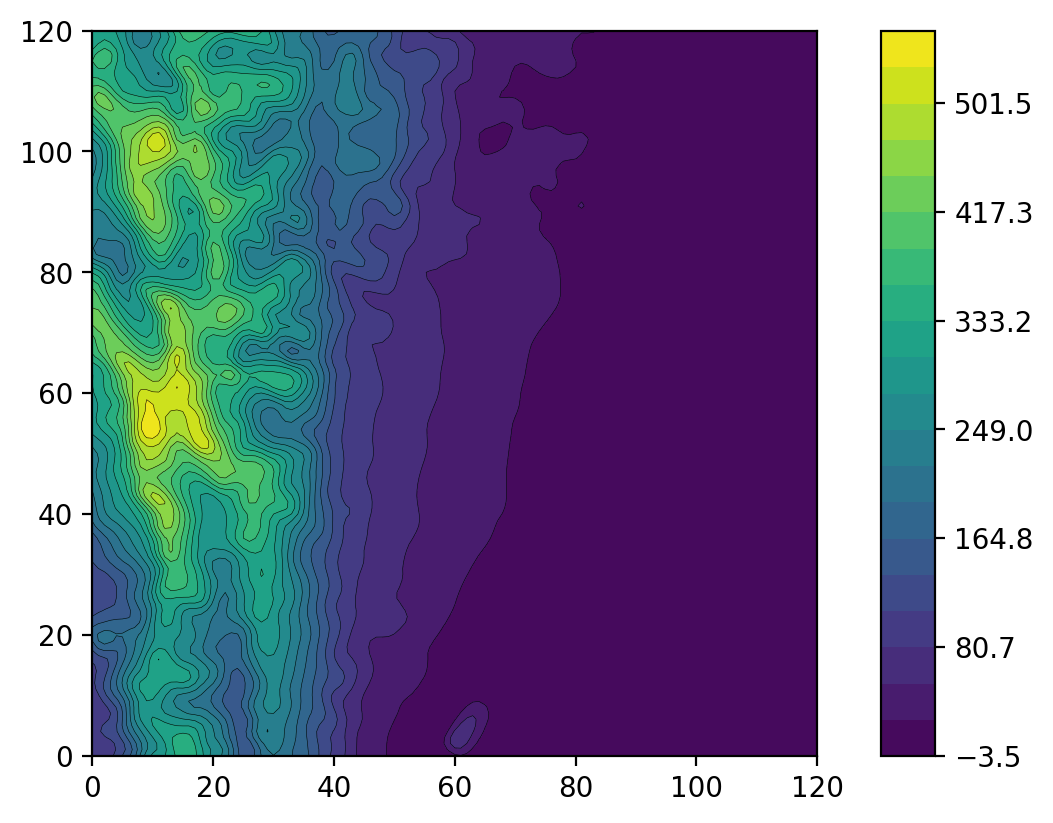

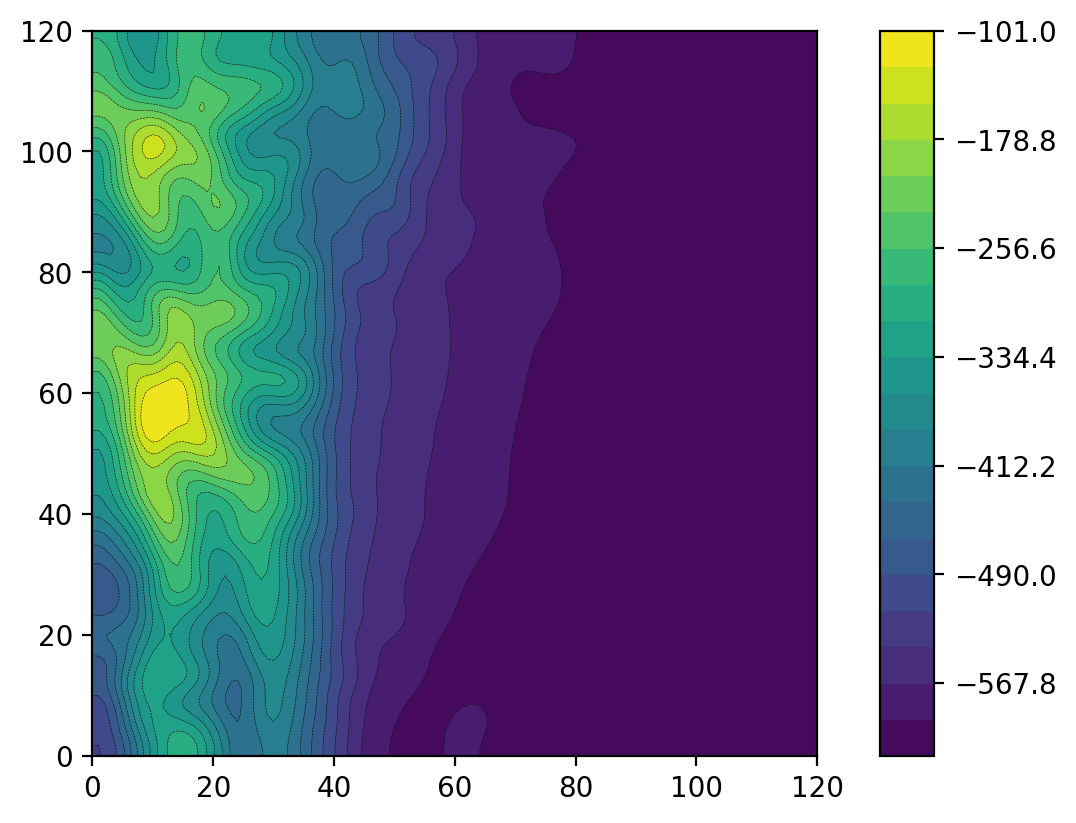

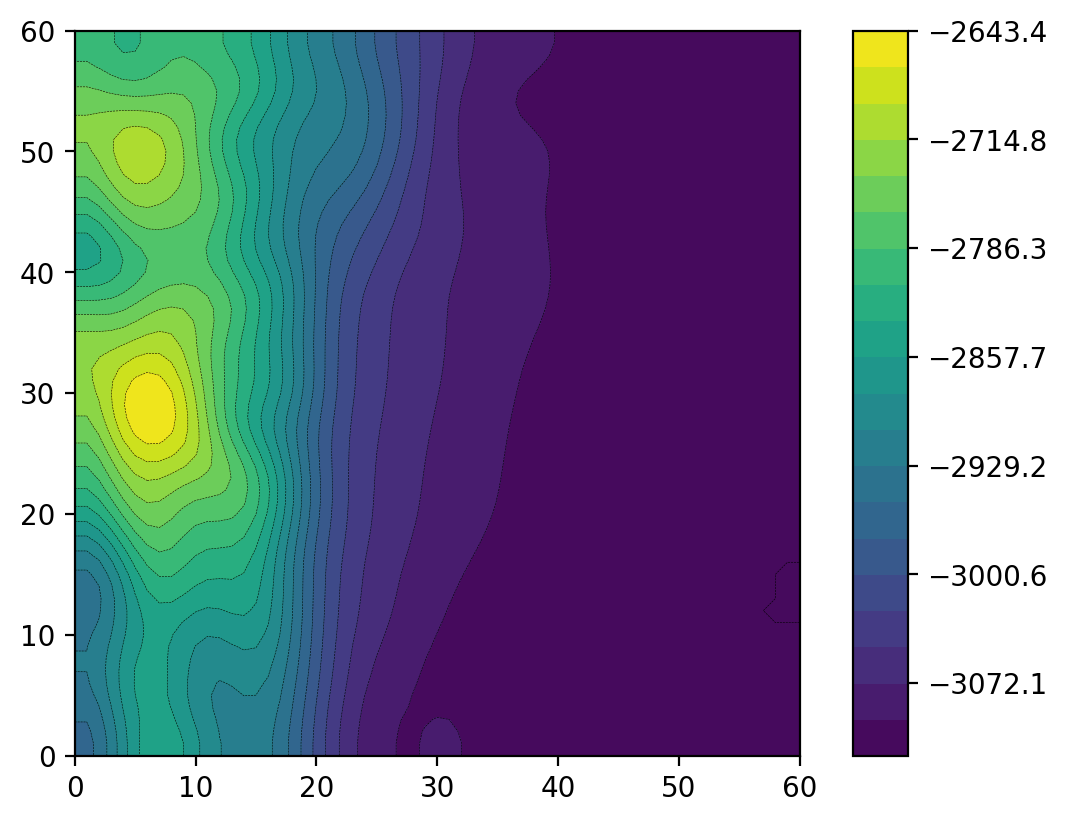

In [4]:
fname='/global/u1/h/houhun/sw4/examples/sfile/berkeley.sfile'
for i in range(0, get_ngrid_sfile(fname)):
    plot_sfile_intf(fname, i)

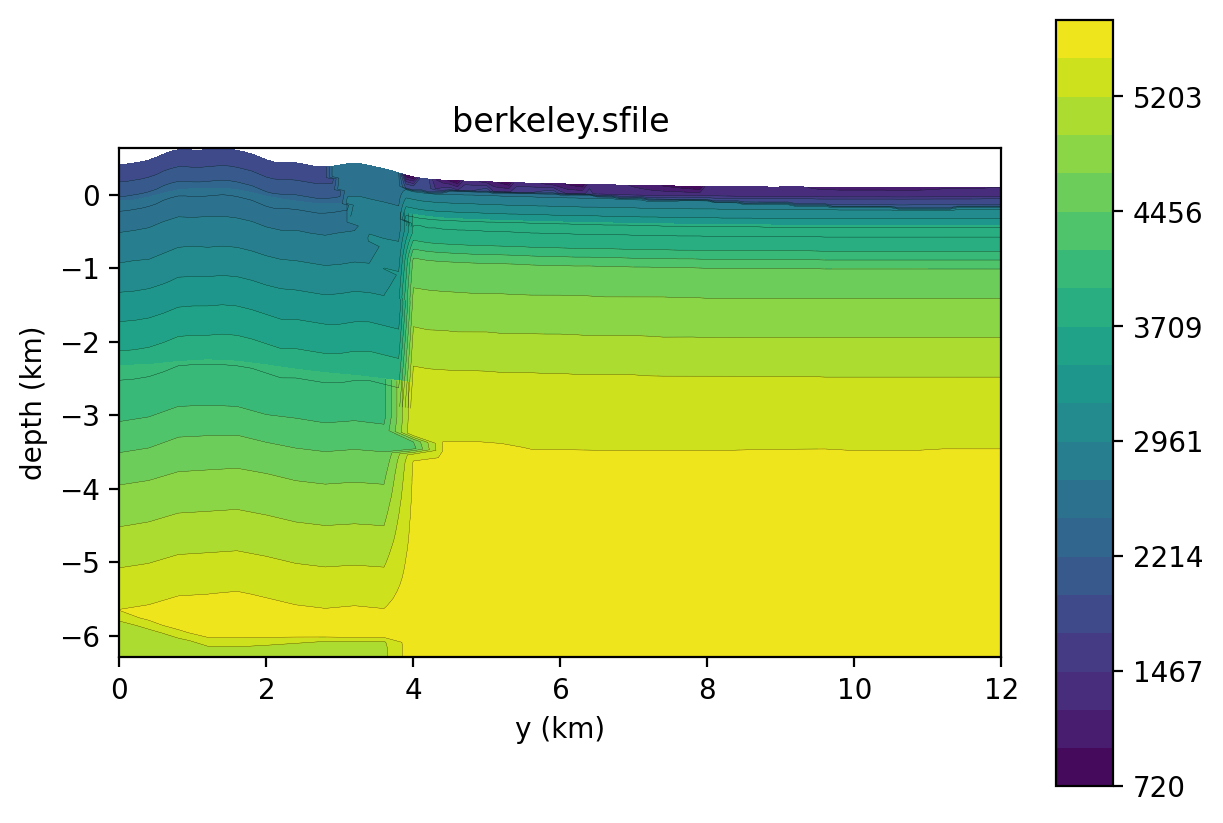

In [5]:
fname='/global/u1/h/houhun/sw4/examples/sfile/berkeley.sfile'
var='Cp'
plane='x'
val=6000

plot_sfile(fname, var, plane, val)

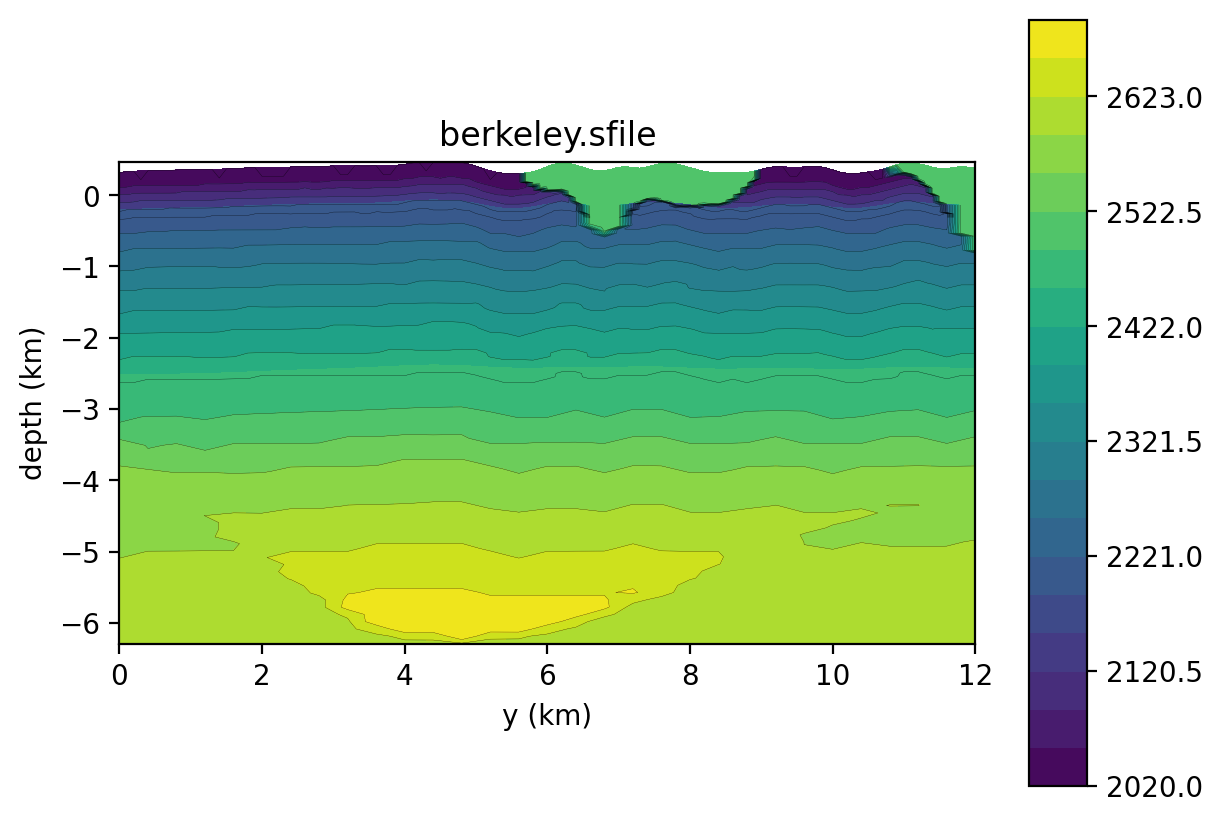

In [6]:
fname='/global/u1/h/houhun/sw4/examples/sfile/berkeley.sfile'
var='Rho'
plane='y'
val=3000

plot_sfile(fname, var, plane, val)

currently only support plotting z plane depth (m), plotted data plane is parallel to the interface (not flat)


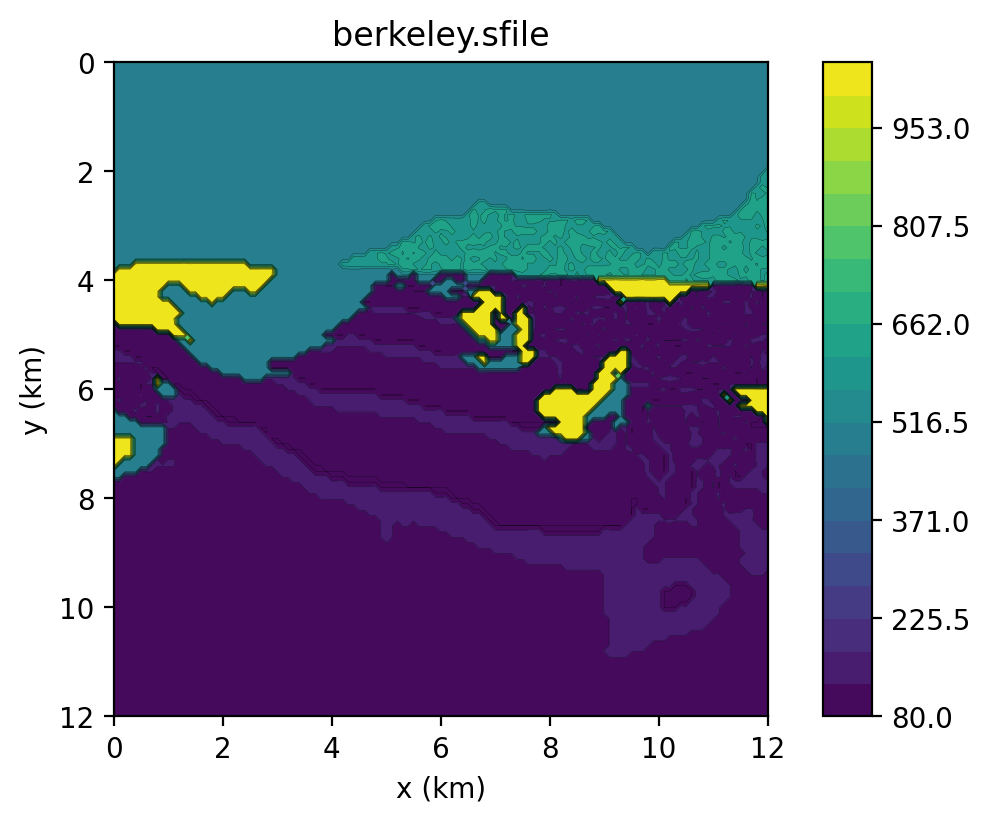

In [7]:
fname='/global/u1/h/houhun/sw4/examples/sfile/berkeley.sfile'
var='Cs'
plane='z'
val=0

plot_sfile(fname, var, plane, val)